# Probability calibration

Probability calibration can provide the probability to get the label s.t. you can have a better understanding of the model.

## Calibration Curve

Calibration curves, also referred to as reliability diagrams (Wilks 1995 [2]), compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability P(Y=1|predict_data)) on the y-axis against the predicted probability predict_proba of a model on the x-axis. The tricky part is to get values for the y-axis. In scikit-learn, this is accomplished by binning the predictions such that the x-axis represents the average predicted probability in each bin. The y-axis is then the fraction of positives given the predictions of that bin, i.e. the proportion of samples whose class is the positive class (in each bin).

The top calibration curve plot is created with CalibrationDisplay.from_estimator, which uses calibration_curve to calculate the per bin average predicted probabilities and fraction of positives. CalibrationDisplay.from_estimator takes as input a fitted classifier, which is used to calculate the predicted probabilities. The classifier thus must have predict_proba method. For the few classifiers that do not have a predict_proba method, it is possible to use CalibratedClassifierCV to calibrate the classifier outputs to probabilities.

## Difference between Different methods

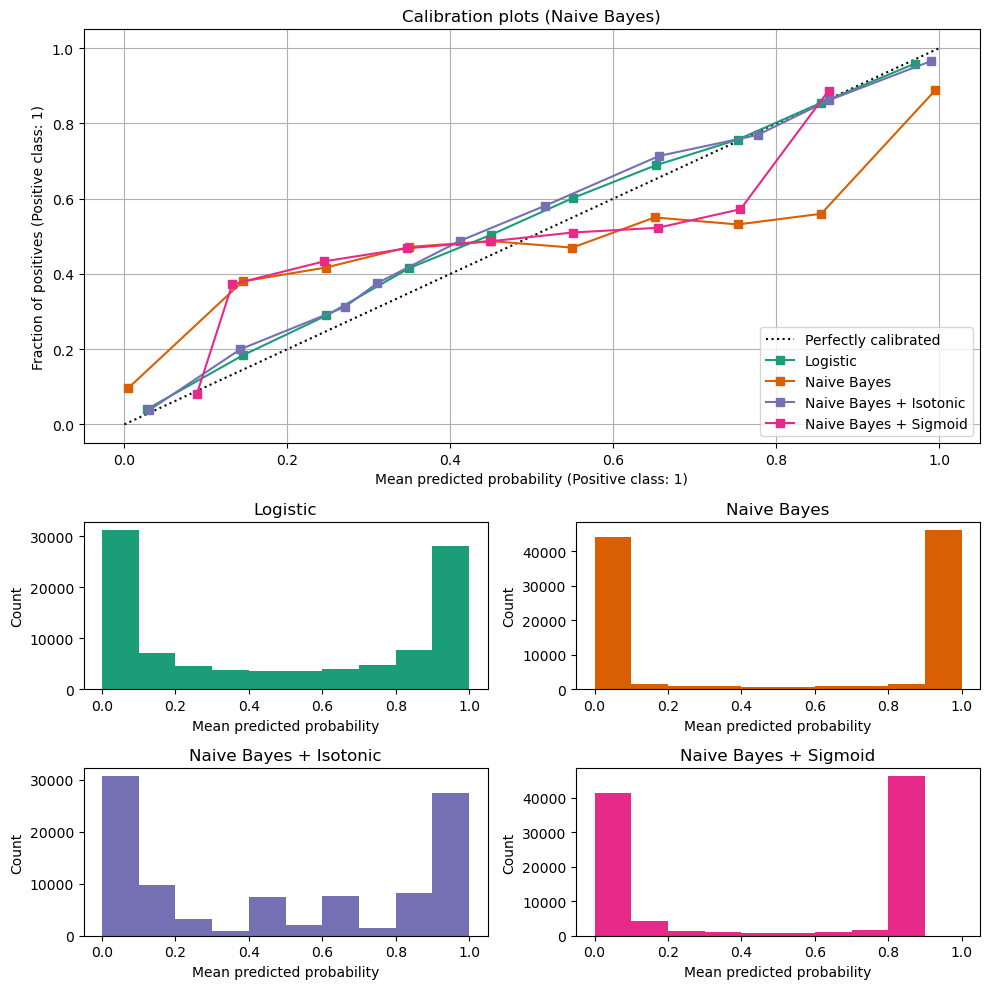

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Sigmoid and Isotonic

- Sigmoid
  - In general this method is most effective for small sample sizes or when the un-calibrated model is under-confident and has similar calibration errors for both high and low outputs.
- Isotonic
  - Overall, ‘isotonic’ will perform as well as or better than ‘sigmoid’ when there is enough data (greater than ~ 1000 samples) to avoid overfitting

## Different Metric

In [2]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098921,0.323178,0.937457,0.872009,0.851408,0.861586
Naive Bayes,0.117608,0.782755,0.940374,0.857400,0.875941,0.866571
Naive Bayes + Isotonic,0.098332,0.370738,0.938613,0.883065,0.836224,0.859007
Naive Bayes + Sigmoid,0.108880,0.368896,0.940201,0.861106,0.871277,0.866161


## Multiclass Problems

Both isotonic and sigmoid regressors only support 1-dimensional data (e.g., binary classification output) but are extended for multiclass classification if the base_estimator supports multiclass predictions. For multiclass predictions, CalibratedClassifierCV calibrates for each class separately in a OneVsRestClassifier fashion [5]. When predicting probabilities, the calibrated probabilities for each class are predicted separately. As those probabilities do not necessarily sum to one, a postprocessing is performed to normalize them.

## Linear support vector classifier

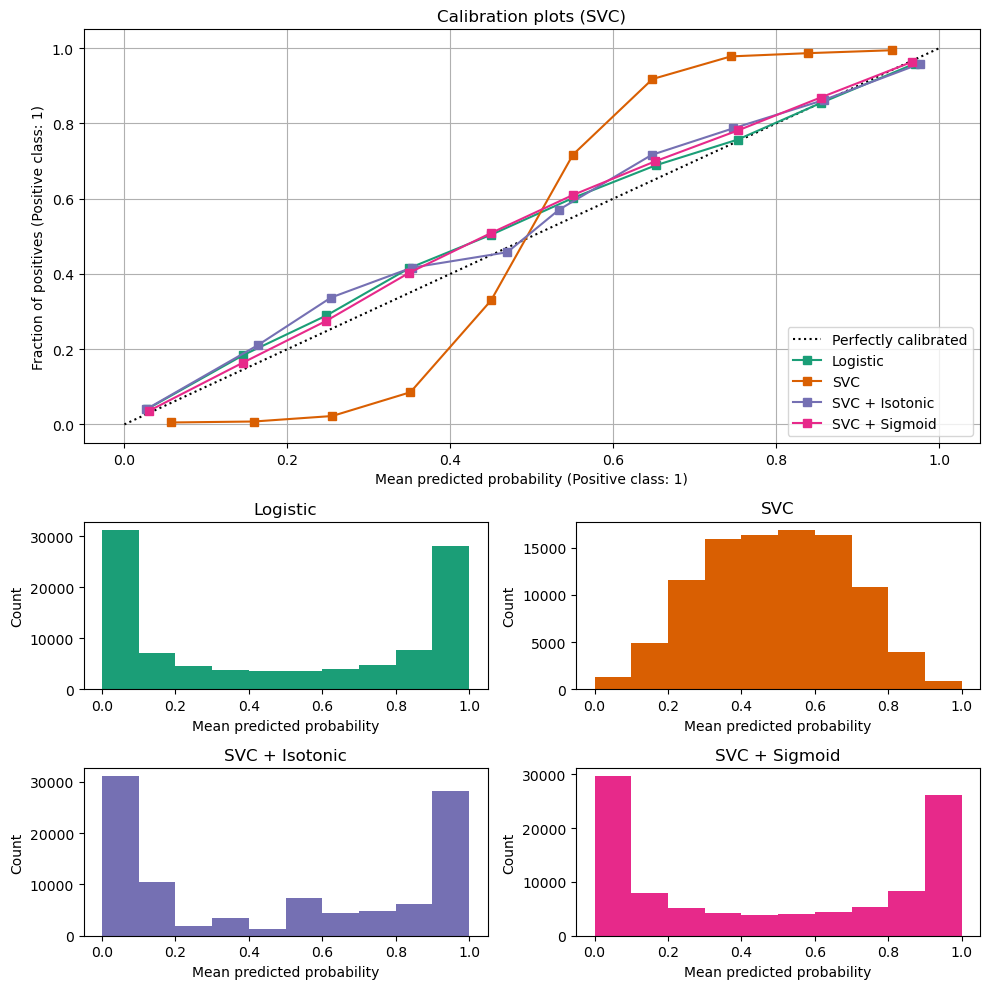

In [4]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000, dual="auto")
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()